# Import Essential Libraries

In [19]:
%pip install -r "/Users/foongyihao/Desktop/FIT3162/FYP/FIT3162-Leveraging-Emotional-Cues-for-Real-Time-Deception-Detection/model/deeplie-requirements.txt"

Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys, os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import tensorflow as tf
from tensorflow.python.framework import type_spec
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.saving import register_keras_serializable

Make sure that we are using a GPU for tensorflow

In [4]:
import tensorflow as tf

# detect whether or not GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU Devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Part 1: Facial Expression Recognition

## Preprocessing
Using the built FER2013 model
Reference:
1. Facial Emotion Recognition on FER2013 Dataset Using a Convolutional Neural Network
https://github.com/gitshanks/fer2013
2. Kaggle challenge (FER-2013): https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [7]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

pathname = 'content/fer2013/'
data = pd.read_csv(pathname+'fer2013.csv')

width, height = 48, 48

In [8]:
datapoints = data['pixels'].tolist()

# getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

# getting labels for training
y = pd.get_dummies(data['emotion']).values

print(f"X.shape={X.shape}, y.shape={y.shape}")
# storing them using numpy
np.save(pathname+'fdataX', X)
np.save(pathname+'flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: " + str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")


X.shape=(35887, 48, 48, 1), y.shape=(35887, 7)
Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


In [14]:
import cv2

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def get_face_from_image(img):
  # resized_image = image_resize(img, width=1000)
  gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  faces = face.detectMultiScale(gray, 1.2, 5)
  return (True, faces[0]) if len(faces)>0 else (False, None)

## Train FER
We do not necessarily need to train a new one. Just use the existing parameters for now. This section is useful for identifying the ConvNet structure used to train the model.

Reference: Facial Emotion Recognition on FER2013 Dataset Using a Convolutional Neural Network
https://github.com/gitshanks/fer2013

In [11]:
x = np.load(pathname+'fdataX.npy')
y = np.load(pathname+'flabels.npy')

# Compute mean and standard deviation
mean_x = np.mean(x, axis=0)  # Shape: (48, 48, 1)
std_x = np.std(x, axis=0)    # Shape: (48, 48, 1)

# Save to project_path
np.save(os.path.join(pathname, "mean_x.npy"), mean_x)
np.save(os.path.join(pathname, "std_x.npy"), std_x)

In [12]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

x = np.load(pathname+'fdataX.npy')
y = np.load(pathname+'flabels.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save(pathname+'modXtest', X_test)
np.save(pathname+'modytest', y_test)

#desinging the CNN
def create_model(n_hidden_conv_layers = 3):
  model = Sequential()

  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  for i in range(n_hidden_conv_layers):
    model.add(Conv2D(2**(i+1)*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2**(i+1)*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4)) #0.4
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4)) #0.4
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5)) #0.5

  model.add(Dense(num_labels, activation='softmax'))
  return model

# with strategy.scope():
model = create_model()
#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=['accuracy'])



2025-03-31 15:56:33.285225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-31 15:56:33.285288: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
#training the model
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

#saving the  model to be used later
fer_json = model.to_json()
with open(pathname+"fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights(pathname+"fer.weights.h5")
print("Saved model to disk")

model.save(pathname + "fer.keras")
print("Saved model to disk in .keras format")

Epoch 1/100


2025-03-31 15:59:30.341332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


455/455 ━━━━━━━━━━━━━━━━━━━━ 95s 189ms/step - accuracy: 0.2006 - loss: 2.4154 - val_accuracy: 0.2594 - val_loss: 1.8160
Epoch 2/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 86s 189ms/step - accuracy: 0.2334 - loss: 1.8584 - val_accuracy: 0.2594 - val_loss: 1.8011
Epoch 3/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 105s 231ms/step - accuracy: 0.2481 - loss: 1.8337 - val_accuracy: 0.2598 - val_loss: 1.8079
Epoch 4/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 108s 236ms/step - accuracy: 0.2480 - loss: 1.8077 - val_accuracy: 0.2728 - val_loss: 1.7735
Epoch 5/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 109s 239ms/step - accuracy: 0.2687 - loss: 1.7814 - val_accuracy: 0.3235 - val_loss: 1.6831
Epoch 6/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 110s 241ms/step - accuracy: 0.3051 - loss: 1.7111 - val_accuracy: 0.3715 - val_loss: 1.5448
Epoch 7/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 114s 250ms/step - accuracy: 0.3499 - loss: 1.6138 - val_accuracy: 0.4090 - val_loss: 1.4681
Epoch 8/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 101s 223ms/step - accuracy: 0.3816 - loss:

**Model Output**
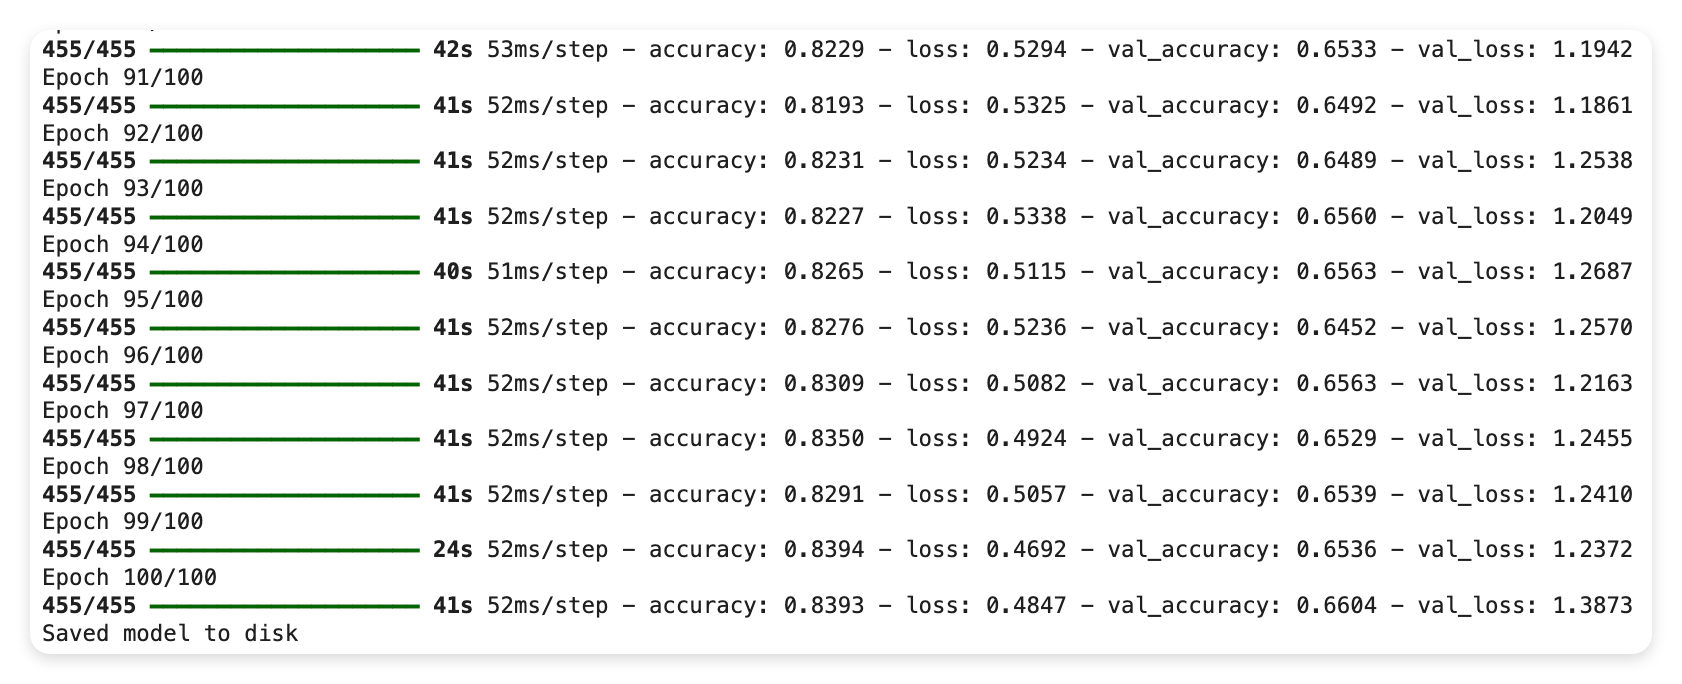

## Test FER

In [3]:
pathname = 'content/fer2013/'

custom_objects = {"categorical_crossentropy": tf.keras.losses.categorical_crossentropy}
loaded_model = tf.keras.models.load_model(pathname + "fer.keras", custom_objects=custom_objects)
print("Loaded model from disk")

2025-03-31 20:23:29.665326: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-31 20:23:29.665350: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-31 20:23:29.665354: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-31 20:23:29.665366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-31 20:23:29.665376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loaded model from disk


In [ ]:
# load json and create model
from __future__ import division
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json
import numpy
import os
import numpy as np

truey=[]
predy=[]
x = np.load(pathname+'modXtest.npy')
y = np.load(pathname+'modytest.npy')

yhat= loaded_model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save(pathname+'truey', truey)
np.save(pathname+'predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Predicted and true label values saved
Accuracy on test set :63.10950125383115%


# Part 2: Lie Detection in Video

To calculate confusion matrix:

In [16]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels = ['deceptive', 'truthful'], title='Confusion Matrix'):
  cm = confusion_matrix(y_true, y_pred)
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()

Define paths to be used later

In [17]:
import pandas as pd

# define paths
drive_path = 'content/deep-lie/'
video_path = "../../data/MU3D/Videos/"
frames_path_300 = "../../data/MU3D/dataset_300_3_points/"
project_path = drive_path + "project/"
video_dir_path = "../../data/MU3D/MU3D Codebook.xlsx"

Create a video dictionary to map IDs to labels

In [20]:
video_data = pd.read_excel(video_dir_path, sheet_name='Video-Level Data')

video_filenames = video_data['VideoID'].tolist()
labels = video_data['Veracity'].tolist()

video_dict = dict(zip(video_filenames, labels))
print(video_dict)

{'BF001_1PT': 1, 'BF001_2NL': 0, 'BF001_3NT': 1, 'BF001_4PL': 0, 'BF002_1PT': 1, 'BF002_2NL': 0, 'BF002_3NT': 1, 'BF002_4PL': 0, 'BF003_1PT': 1, 'BF003_2NL': 0, 'BF003_3NT': 1, 'BF003_4PL': 0, 'BF004_1PT': 1, 'BF004_2NL': 0, 'BF004_3NT': 1, 'BF004_4PL': 0, 'BF006_1PT': 1, 'BF006_2NL': 0, 'BF006_3NT': 1, 'BF006_4PL': 0, 'BF008_1PT': 1, 'BF008_2NL': 0, 'BF008_3NT': 1, 'BF008_4PL': 0, 'BF013_1PT': 1, 'BF013_2NL': 0, 'BF013_3NT': 1, 'BF013_4PL': 0, 'BF014_1PT': 1, 'BF014_2NL': 0, 'BF014_3NT': 1, 'BF014_4PL': 0, 'BF015_1PT': 1, 'BF015_2NL': 0, 'BF015_3NT': 1, 'BF015_4PL': 0, 'BF016_1PT': 1, 'BF016_2NL': 0, 'BF016_3NT': 1, 'BF016_4PL': 0, 'BF018_1PT': 1, 'BF018_2NL': 0, 'BF018_3NT': 1, 'BF018_4PL': 0, 'BF019_1PT': 1, 'BF019_2NL': 0, 'BF019_3NT': 1, 'BF019_4PL': 0, 'BF020_1PT': 1, 'BF020_2NL': 0, 'BF020_3NT': 1, 'BF020_4PL': 0, 'BF022_1PT': 1, 'BF022_2NL': 0, 'BF022_3NT': 1, 'BF022_4PL': 0, 'BF023_1PT': 1, 'BF023_2NL': 0, 'BF023_3NT': 1, 'BF023_4PL': 0, 'BF024_1PT': 1, 'BF024_2NL': 0, 'BF024_

### Some helper functions and one-time read / write operations (don't worry about it)
Define function to create paths, read and process videos

In [21]:
def create_path(path):
  try:
    if not os.path.exists(path):
      os.makedirs(path)
  except OSError:
    print(f"Error: Creating directory: {path}")

In [23]:
from alive_progress import alive_bar

def preprocess_image(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # we turn the image to grayscale
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(gray_img, (48, 48)), -1), 0)
  cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
  return cropped_img

# Using the 300 frames dataset
# Saves the cropped facial image
def read_video_300(filename):
    folder = os.path.join(frames_path_300, filename)
    frame_files = sorted(os.listdir(folder))

    # Initialize an array to store the flattened cropped images for 300 frames
    xdata = np.zeros((300, 48*48))
    frame_count = 0

    for frame_file in frame_files:
        if frame_count >= 300: break # limit the max number of frames we examine

        frame_path = os.path.join(folder, frame_file)
        frame_image = cv2.imread(frame_path)

        if frame_image is None: continue # skip frames cannot be loaded

        # Preprocess and flatten
        cropped_img = preprocess_image (frame_image) # resize/normalize to 48x48
        xdata[frame_count, :] = cropped_img.flatten()
        frame_count += 1

    # Release all space and windows once done
    cv2.destroyAllWindows()

    return xdata

def saveData(X, y):
  X = np.asarray(X)
  y = np.asarray(y)
  np.save(project_path+'fdataX', X)
  np.save(project_path+'flabels', y)


X = []
y = []

count = 0
with alive_bar(len(video_dict), force_tty=True) as bar:

  for (k, v) in video_dict.items():
    count+=1
    xi = read_video_300(k)
    X.append(xi)
    y.append(v)
    if count % 5 == 0:
      saveData(X, y)
    bar()

saveData(X, y)
print(f"\nComplete saving {count} number of data")


|████████████████████████████████████████| 320/320 [100%] in 2:00.6 (2.65/s)                                            

Complete saving 320 number of data


Visualise the dataset

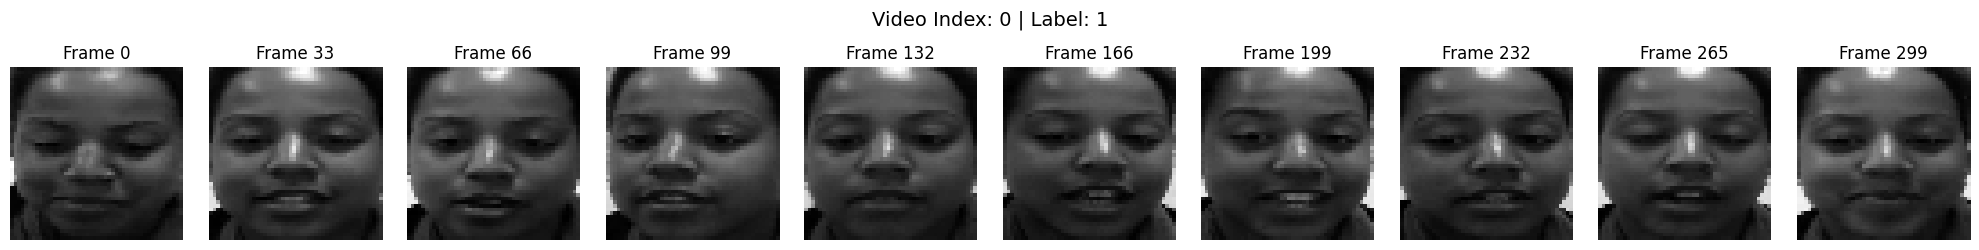

In [24]:
import numpy as np
import matplotlib.pyplot as plt

X = np.load(project_path + 'fdataX.npy')  # shape: (num_videos, 300, 48*48)
y = np.load(project_path + 'flabels.npy') # shape: (num_videos,)

def display_video_sample(video_index, num_frames=10):
    """
    Displays num_frames (evenly spaced) from the video sample at video_index.
    """
    # Get the video sample and its corresponding label
    video_data = X[video_index]  # shape: (300, 48*48)
    label = y[video_index]

    # Choose evenly spaced indices to display frames
    indices = np.linspace(0, video_data.shape[0] - 1, num_frames, dtype=int)

    # Create a figure with subplots
    fig, axs = plt.subplots(1, num_frames, figsize=(num_frames*2, 2.5))
    fig.suptitle(f"Video Index: {video_index} | Label: {label}", fontsize=14)

    # Iterate over selected frame indices and plot each frame
    for i, idx in enumerate(indices):
        frame = video_data[idx].reshape(48, 48)  # reshape from flattened to 48x48
        axs[i].imshow(frame, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"Frame {idx}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example: Display sample frames for the first video (index 0)
display_video_sample(0)

## Train DNN

In [25]:
import sys, os
import pandas as pd
import numpy as np

from tensorflow.keras import initializers
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Masking, GRU
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import tensorflow as tf
import matplotlib.pyplot as plt

In [26]:
X = np.load(project_path+'fdataX.npy')
y = np.load(project_path+'flabels.npy')

print('Loaded data', X.shape, y.shape)

Loaded data (320, 300, 2304) (320,)


In [27]:
X = np.reshape(X,(X.shape[0], X.shape[1], 48, 48))
X = np.expand_dims(X, -1)
X.shape

(320, 300, 48, 48, 1)

### Gated Recurrent Units (GRU) Model

In [29]:
from alive_progress import alive_bar

# load the layers from the pre-trained, loaded model
layer_names = [layer.name for layer in loaded_model.layers]
layer_outputs = [layer.output for layer in loaded_model.layers]
print(f"layer_names total: {len(layer_names)}")

# pre-process input X
X -= np.mean(X, axis=0)
X /= (np.std(X, axis=0) + 1e-8)

# for each entry, we will convert each of the 300 images (48, 48, 1) to encoding vectors
encoding_model = Model(inputs = loaded_model.inputs, outputs = layer_outputs[23])

X_cnn = np.zeros((X.shape[0], X.shape[1], 4608))
i = 0
with alive_bar(len(X), force_tty=True) as bar:
  for (xi, yi) in zip(X, y):
    predictedX = encoding_model.predict(xi, verbose=0)
    X_cnn[i] = predictedX
    i+=1
    bar()

#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.1, random_state=1) # random_state=42
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=7) # random_state=41

#saving the test samples to be used later
np.save(project_path+'modXtest', X_test)
np.save(project_path+'modytest', y_test)


layer_names total: 31
|                                        | ▄▆█ 0/320 [0%] in 0s (0.0/s, eta: -) 

2025-03-31 20:47:07.192428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


|████████████████████████████████████████| 320/320 [100%] in 59.4s (5.39/s)                                             


Visualise the encoded training data

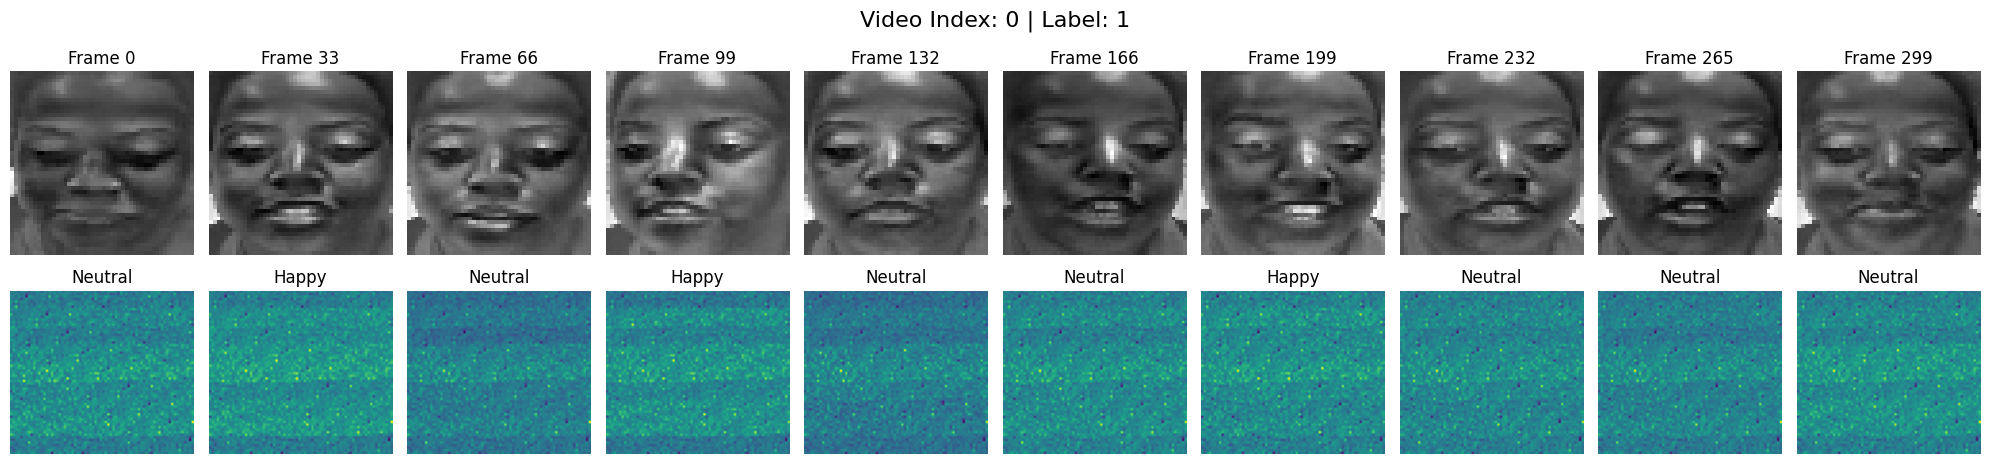

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_expression(frame_48x48):
    """
    Predicts the facial expression using the loaded FER model.
    'frame_48x48' should be a 48x48 grayscale image (float32).
    Returns a string label for the top predicted emotion.
    """
    # Model expects (batch_size, 48, 48, 1) if that's how it was trained.
    # Expand dims to create batch and channel dimension.
    input_batch = np.expand_dims(frame_48x48, axis=-1)  # (48,48) -> (48,48,1)
    input_batch = np.expand_dims(input_batch, axis=0)   # -> (1,48,48,1)

    # Predict probabilities for each of the 7 classes
    probs = loaded_model.predict(input_batch, verbose=0)[0]  # shape (7,)
    top_idx = np.argmax(probs)
    return label_names[top_idx]

def display_video_with_encoding(video_index, num_frames=10):
    """
    Displays a sample video with:
      - Top row: Original frames (48x48) + predicted expression in title
      - Bottom row: Encoding heatmaps (reshaped to 64x72)
    """
    # Retrieve the video sample (300 frames) and its encoding
    video_frames = X[video_index]      # shape: (300, 48*48)
    encodings = X_cnn[video_index]     # shape: (300, 4608)

    # If y is one-hot or multi-hot, you can decode it;
    # otherwise, this might be an integer or string label already.
    # Here we just show the raw label as an example:
    raw_label = y[video_index]

    # Evenly spaced frame indices
    indices = np.linspace(0, video_frames.shape[0] - 1, num_frames, dtype=int)

    # Create a figure with two rows
    fig, axs = plt.subplots(2, num_frames, figsize=(num_frames*2, 5))
    fig.suptitle(f"Video Index: {video_index} | Label: {raw_label}", fontsize=16)

    for j, idx in enumerate(indices):
        # ----------------------------
        # TOP ROW: Original frame
        # ----------------------------
        # Convert flattened 48*48 to (48,48)
        frame_2d = video_frames[idx].reshape(48, 48).astype('float32')

        axs[0, j].imshow(frame_2d, cmap='gray')
        axs[0, j].axis('off')
        axs[0, j].set_title(f"Frame {idx}")

        # ----------------------------
        # BOTTOM ROW: Encoding heatmap
        # ----------------------------
        encoding_frame = encodings[idx].reshape(64, 72)
        # Predict the expression using the loaded FER model
        predicted_expr = predict_expression(frame_2d)
        im = axs[1, j].imshow(encoding_frame, cmap='viridis')
        axs[1, j].axis('off')
        axs[1, j].set_title(f"{predicted_expr}")


    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

display_video_with_encoding(0)


In [31]:
print(X_train.shape, y_train.shape)
m = X_train.shape[0]
Tx = X_train.shape[1]
dims = X_train.shape[2]

(259, 300, 4608) (259,)


In [32]:

# train a GRU network for binary classification
def create_gru_model(input_shape):
  X_input = Input(shape=input_shape)
  X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input) #filters = 196, kernel_size = 15
  X = MaxPooling1D(pool_size=30, strides=15, padding='same')(X) # pool 30, strides 15 is fine!
  X = BatchNormalization()(X)
  X = Activation("relu")(X)
  X = Dropout(rate=0.8)(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  # X = GRU(units=128, return_sequences=True)(X)
  X = GRU(units=128, return_sequences=False)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = Dropout(rate=0.8)(X) #0.8 is fine!

  X = Dense(1, activation="sigmoid")(X)

  model = Model(inputs=X_input, outputs=X)

  return model

gru_model = create_gru_model(input_shape=(Tx, dims))
gru_model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 4608)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d (Conv1D)                 │ (None, 72, 196)           │ 13,547,716 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 196)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 5, 196)            │        784 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation (Activation)         │ (None, 5, 196)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 5, 196)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru (GRU)                       │ (None, 5, 128)            │    125,184 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 5, 128)            │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_1 (GRU)                     │ (None, 128)               │     99,072 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 128)               │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 13,773,909 (52.54 MB)

 Trainable params: 13,773,005 (52.54 MB)

 Non-trainable params: 904 (3.53 KB)

In [33]:
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(259, 300, 4608)
(259,)


In [36]:
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(
    learning_rate=0.001, # 0.001
    beta_1=0.9,
    beta_2=0.999,
    decay=0.01,  # 0.01
    epsilon=1e-7
  ), metrics=['accuracy'])

gru_model.fit(np.array(X_train), np.array(y_train),
          batch_size=64,
          epochs=150,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True,
  )


# evaluate the keras model
_, accuracy = gru_model.evaluate(X_valid, y_valid)
acc_str = '%.2f' % (accuracy*100)
print(f'Accuracy: {acc_str}%')


#saving the  model to be used later
folder_path = 'gru_model/'
loocv_gru_path = os.path.join(project_path, folder_path)
gru_model.save(project_path + folder_path + "gru_model_" + acc_str + ".keras")

print(f"Scores and model saved to: {folder_path}")

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4877 - loss: 0.7079 - val_accuracy: 0.3103 - val_loss: 0.6994
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 560ms/step - accuracy: 0.4955 - loss: 0.7009 - val_accuracy: 0.3793 - val_loss: 0.7000
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - accuracy: 0.5247 - loss: 0.6823 - val_accuracy: 0.3793 - val_loss: 0.7013
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.4978 - loss: 0.6993 - val_accuracy: 0.4138 - val_loss: 0.7020
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.5075 - loss: 0.6984 - val_accuracy: 0.4483 - val_loss: 0.7024
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - accuracy: 0.5034 - loss: 0.7014 - val_accuracy: 0.4483 - val_loss: 0.7023
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.4906 - loss: 0.6976 - val_accuracy: 0.4483 - val_loss: 0.7018
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - accuracy: 0.4502 - loss: 0.7103 - val_accuracy: 0.4483 - val

**Model outputs**
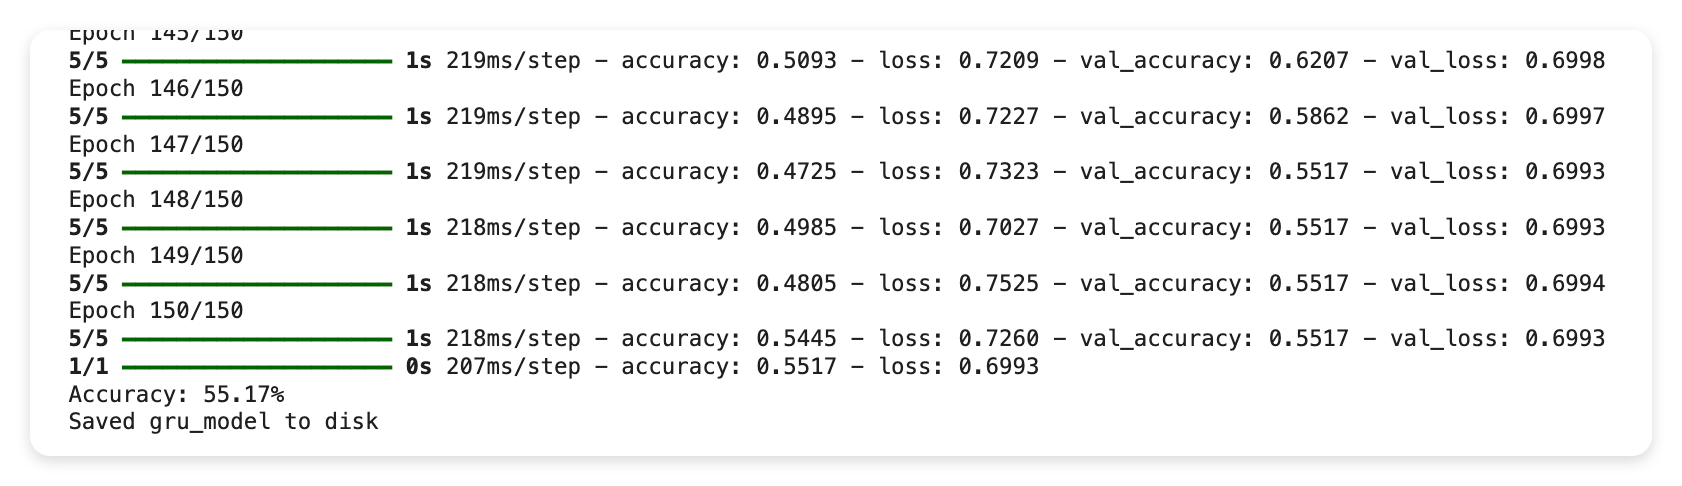

#### Leave-one-out cross validation evaluation

According to "Video Based Deception Detection Using Deep Recurrent Convolutional Neural Network" (CVIP 2019) by Sushma Venkatesh, Raghavendra Ramachandra, Patrick Bours, using Leave-one-out cross validation across 25 trials, they have achieved 100% accuracy on the same dataset (121 trial videos) using Deep Recurrent Convolutional Neural Network.

In [37]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
# X = np.array([[1, 2], [3, 4]])
# y = np.array([1, 2])
loo = LeaveOneOut()
loo.get_n_splits(X)
print(loo)

acc_per_trial = []
loss_per_trial = []

trial = 0
for train_index, test_index in loo.split(X_cnn):
    trial += 1
    X_train, X_valid = X_cnn[train_index], X_cnn[test_index]
    y_train, y_valid = y[train_index], y[test_index]

    gru_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.01, epsilon=1e-7), metrics=['accuracy'])
    history = gru_model.fit(np.array(X_train), np.array(y_train),
              batch_size=64,
              epochs=200, # 150
              verbose=1,
              validation_data=(np.array(X_valid), np.array(y_valid)),
              shuffle=True)
    scores = gru_model.evaluate(X_valid, y_valid, verbose=0)
    print(f'Score for trial {trial}: {gru_model.metrics_names[0]} of {scores[0]}; {gru_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_trial.append(scores[1] * 100)
    loss_per_trial.append(scores[0])


    # evaluate the keras model
    _, accuracy = gru_model.evaluate(X_valid, y_valid)
    acc_str = '%.2f' % (accuracy*100)
    print(f'Accuracy: {acc_str}%')

    if trial == 25: break # we only look at 25 trials



print('------------------------------------------------------------------------')
print('Score per trial')
for i in range(0, len(acc_per_trial)):
  print('------------------------------------------------------------------------')
  print(f'> Trial {i+1} - Loss: {loss_per_trial[i]} - Accuracy: {acc_per_trial[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all trial:')
acc_str = f'{np.mean(acc_per_trial)} (+- {np.std(acc_per_trial)})'
print(f'> Accuracy: {acc_str})')
print(f'> Loss: {np.mean(loss_per_trial)}')
print('------------------------------------------------------------------------')

folder_path = 'gru_model/'
loocv_gru_path = os.path.join(project_path, folder_path)
gru_model.save(project_path + folder_path + "gru_model_(LOOCV)_" + acc_str + ".keras")

print(f"Scores and model saved to: {folder_path}")

LeaveOneOut()
Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4604 - loss: 0.6970 - val_accuracy: 0.0000e+00 - val_loss: 0.7412
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 575ms/step - accuracy: 0.5270 - loss: 0.6902 - val_accuracy: 0.0000e+00 - val_loss: 0.7313
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.5070 - loss: 0.6988 - val_accuracy: 0.0000e+00 - val_loss: 0.7251
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - accuracy: 0.4970 - loss: 0.6976 - val_accuracy: 0.0000e+00 - val_loss: 0.7246
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - accuracy: 0.4963 - loss: 0.7011 - val_accuracy: 0.0000e+00 - val_loss: 0.7242
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - accuracy: 0.4978 - loss: 0.6988 - val_accuracy: 0.0000e+00 - val_loss: 0.7154
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - accuracy: 0.4924 - loss: 0.7044 - val_accuracy: 0.0000e+00 - val_loss: 0.7095
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - accuracy: 0.4771 -

#### Siamese Network with Triplet Loss for Classification

First we generate dataset for the triplet loss.

Then we train a 2-layer GRU model to output a 128-dim encoding vector for each preprocessed video input.

Finally, we store the average encoding vector for positive and negative classes for later use.



---



Whenever there is a new video, we simply

1) get the preprocessed video as a vector

2) compare the distance(average_positive_encoding, video_encoding) vs. distance(average_negative_encoding, video_encoding) to assign a label 0 or 1.

In [47]:
# Data preprocessing
X_train = X_train.reshape(X_train.shape[0], 300, 4608)
print(X_train.shape, y_train.shape)
input_shape = X_train.shape[1:]
print(f"input_shape={input_shape}")

X_valid = X_valid.reshape(X_valid.shape[0], 300, 4608)

(319, 300, 4608) (319,)
input_shape=(300, 4608)


In [48]:
import random

# Returns a list of randomly generated anchors, positives and negatives
# of size batch_size (default to 5000)
def create_batch(batch_size=5000):
    x_anchors = np.zeros((batch_size, 300, 4608))
    x_positives = np.zeros((batch_size, 300, 4608))
    x_negatives = np.zeros((batch_size, 300, 4608))

    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, X_train.shape[0] - 1)
        x_anchor = X_train[random_index]
        y = y_train[random_index]

        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))

        x_positive = X_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = X_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]

        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative

    return [x_anchors, x_positives, x_negatives]

In [49]:
emb_size = 64

def create_embedding_model(input_shape):
  X_input = Input(shape=input_shape)
  X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input) #filters = 196, kernel_size = 15
  # X = MaxPooling1D(pool_size=15)(X)
  X = MaxPooling1D(pool_size=30, strides=15, padding='valid')(X) # pool 30, strides 15 is fine!
  X = BatchNormalization()(X)
  X = Activation("relu")(X)
  X = Dropout(rate=0.8)(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = Dropout(rate=0.5)(X) #0.8 is fine!

  X = Flatten()(X)
  X = Dense(emb_size, activation="sigmoid")(X)

  model = Model(inputs=X_input, outputs=X)

  return model

embedding_model=create_embedding_model(input_shape=(Tx, dims))
embedding_model.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 300, 4608)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_2 (Conv1D)               │ (None, 72, 196)           │ 13,547,716 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 196)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_6           │ (None, 3, 196)            │        784 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_2 (Activation)       │ (None, 3, 196)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_8 (Dropout)             │ (None, 3, 196)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_4 (GRU)                     │ (None, 3, 128)            │    125,184 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 128)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_7           │ (None, 3, 128)            │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ gru_5 (GRU)                     │ (None, 3, 128)            │     99,072 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 128)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_8           │ (None, 3, 128)            │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_11 (Dropout)            │ (None, 3, 128)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 384)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 64)                │     24,640 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 13,798,420 (52.64 MB)

 Trainable params: 13,797,516 (52.63 MB)

 Non-trainable params: 904 (3.53 KB)

In [50]:
# Siamese Network

input_anchor = Input(shape=(Tx, dims,))
input_positive = Input(shape=(Tx, dims,))
input_negative = Input(shape=(Tx, dims,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 4608) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_layer_7       │ (None, 300, 4608) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_layer_8       │ (None, 300, 4608) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ functional_40       │ (None, 64)        │ 13,798… │ input_layer_6[0][0], │
│ (Functional)        │                   │         │ input_layer_7[0][0], │
│                     │                   │         │ input_layer_8[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate_1       │ (None, 192)       │       0 │ functional_40[0][0], │
│ (Concatenate)       │                   │         │ functional_40[1][0], │
│                     │                   │         │ functional_40[2][0]  │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 13,798,420 (52.64 MB)

 Trainable params: 13,797,516 (52.63 MB)

 Non-trainable params: 904 (3.53 KB)

In [51]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA

# we will use this function to visualize how the embedding model is doing over time.
class PCAPlotter(tf.keras.callbacks.Callback):

    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()

        self.losses = []

    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()

    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

In [ ]:
# Triplet Loss

alpha = 0.2 # 0.6 was fine

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

# Data Generator

def data_generator(batch_size=64):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield tuple(x), y

# Model Training
batch_size = m
epochs = 100 #int(400000/m/100)
steps_per_epoch = int(m/batch_size)

net.compile(loss=triplet_loss, optimizer=Adam(learning_rate=3e-4, beta_1=0.9, beta_2=0.999, decay=0.01, epsilon=1e-7))


# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=True,
    callbacks=[
        early_stopping_callback,
        PCAPlotter(
            plt, embedding_model,
            X_valid[:1000], y_valid[:1000]
        )]
)

/Users/foongyihao/anaconda3/envs/FIT3181-A1/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:31: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/var/folders/z9/t45r8gqs5w1g3qljdp1bps240000gn/T/ipykernel_3550/4110085363.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


In [45]:
# we need to store the average truth vector
# and the average lie vector learned
# with training set for verify
X_train_emb = embedding_model.predict(X_train)

truth_emb = []
lie_emb = []
for xi, yi in zip(X_train_emb, y_train):
  if yi == 1:
    truth_emb.append(xi)
  else:
    lie_emb.append(xi)
print(f"There are {len(truth_emb)} truths and {len(lie_emb)} lies.")

average_truth_emb = np.mean(truth_emb, axis=0)
average_lie_emb = np.mean(lie_emb, axis=0)

database={}
database['truth'] = average_truth_emb
database['lie'] = average_lie_emb

KeyboardInterrupt: 

Next we will validate results

In [44]:
# Validation Accuracy
X_valid_emb = embedding_model.predict(X_valid)
print(f"X_valid.shape={X_valid.shape}, X_valid_emb.shape={X_valid_emb.shape}, y_valid.shape={y_valid.shape}")

# verify function: given an embedding, will tell whether or not it is truth
# based on distance from the average truth and the average lie vectors.
def verify(emb, embedding_model, database):
  dist_truth = np.linalg.norm(emb - database["truth"])
  dist_lie = np.linalg.norm(emb - database["lie"])
  print(f"dist_truth={dist_truth}, dist_lie={dist_lie}")
  return 1 if dist_truth < dist_lie  else 0


# now we measure the accuracy on validation set.
count = 0
y_pred = []

for emb, y in zip(X_valid_emb, y_valid):
  y_predict = verify(emb, embedding_model, database)
  y_pred.append(y_predict)
  if y_predict == y:
    count += 1
  else:
    print("y_predict: ", y_predict, "y: ", y)


accuracy = count/X_valid_emb.shape[0]
acc_str = '%.2f' % (accuracy*100)
print('Validation Accuracy: '+acc_str+'%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
X_valid.shape=(1, 300, 4608), X_valid_emb.shape=(1, 64), y_valid.shape=(1,)


NameError: name 'database' is not defined

In [ ]:
# Train accuracy
X_train_emb = embedding_model.predict(X_train)
print(f"X_train.shape={X_train.shape}, X_train_emb.shape={X_train_emb.shape}, y_train.shape={y_train.shape}")

# verify function: given an embedding, will tell whether or not it is truth
# based on distance from the average truth and the average lie vectors.
def verify(emb, embedding_model, database):
  dist_truth = np.linalg.norm(emb - database["truth"])
  dist_lie = np.linalg.norm(emb - database["lie"])
  print(f"dist_truth={dist_truth}, dist_lie={dist_lie}")
  return 1 if dist_truth < dist_lie  else 0


# now we measure the accuracy on validation set.
count = 0

y_pred = []
for emb, y in zip(X_train_emb, y_train):
  y_predict = verify(emb, embedding_model, database)
  y_pred.append(y_predict)
  # print("y_predict: ", y_predict, "y: ", y)
  if y_predict == y:
    count += 1
  else:
    print("y_predict: ", y_predict, "y: ", y)

accuracy = count/X_train_emb.shape[0]
acc_str = '%.2f' % (accuracy*100)
print('Train Accuracy: '+acc_str+'%')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
X_train.shape=(259, 300, 4608), X_train_emb.shape=(259, 64), y_train.shape=(259,)
dist_truth=0.4583088755607605, dist_lie=0.4744526147842407
dist_truth=0.48228344321250916, dist_lie=0.5026389360427856
y_predict:  1 y:  0
dist_truth=0.3846721053123474, dist_lie=0.38883161544799805
y_predict:  1 y:  0
dist_truth=0.4237588942050934, dist_lie=0.4446737468242645
dist_truth=0.517842173576355, dist_lie=0.4989689588546753
dist_truth=0.4321351945400238, dist_lie=0.43373730778694153
y_predict:  1 y:  0
dist_truth=0.4278610348701477, dist_lie=0.44708552956581116
dist_truth=0.42330580949783325, dist_lie=0.41071516275405884
y_predict:  0 y:  1
dist_truth=0.5217397212982178, dist_lie=0.49471375346183777
dist_truth=0.5054693222045898, dist_lie=0.5183632969856262
dist_truth=0.3664216995239258, dist_lie=0.3494742810726166
dist_truth=0.4585886001586914, dist_lie=0.48187729716300964
y_predict:  1 y:  0
dist_truth=0.6020605564117432, dist_lie=0.581261396408081
y_predi

In [ ]:
folder_path = 'Siamese Network/'

# Save the embedding model
embedding_model.save(project_path + "embedding_model.keras")
print("Saved embedding model to disk")

# Optionally save the full Siamese network
net.save(project_path + "siamese_net.keras")
print("Saved Siamese network to disk")

# Save the database (average truth and lie embeddings)
np.save(os.path.join(project_path + folder_path, "average_truth_emb.npy"), average_truth_emb)
np.save(os.path.join(project_path + folder_path, "average_lie_emb.npy"), average_lie_emb)
print("Database embeddings saved to Google Drive at:", project_path + folder_path)

Embedding model saved to Google Drive at: /content/drive/MyDrive/FIT3162/deep-lie/Project/Siamese Network/
Database embeddings saved to Google Drive at: /content/drive/MyDrive/FIT3162/deep-lie/Project/Siamese Network/


[[74 56]
 [61 68]]


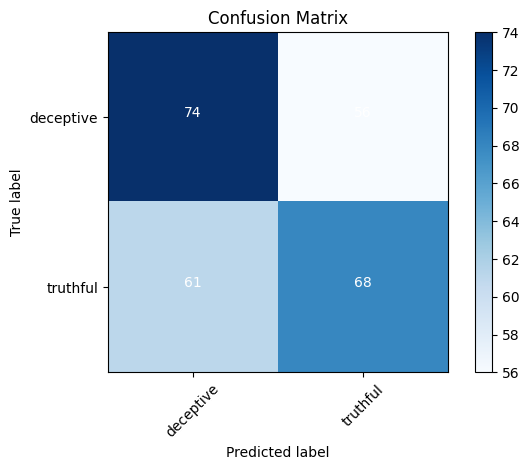

In [ ]:
plot_confusion_matrix(np.array(y_train), np.array(y_pred), title='Confusion Matrix')